# Memory management in Python
Andrew Delman, updated 2024-07-26

## Objectives
Demonstrate how Python objects (variables) are stored in and cleared from memory, and establish good practices for conserving memory in a Python workspace.

## Introduction
Python is a very useful computing language for doing numerical analysis of large datasets, largely because of packages that have been developed specifically for this purpose. [Xarray](https://docs.xarray.dev/en/stable/) allows us to open data from a number of files using a single line of code (with `open_mfdataset`), while [Dask](https://www.dask.org/) makes it easy to parallelize computations and stagger memory usage by "chunking" the computations. However, we still need to be mindful of the memory limitations of our workspace, and there are some quirks to memory management in Python.

## Datasets to download
If you don't have them already, you may need to download the following datasets for the last part of this tutorial.

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4** (1992-2017)


## View vs. copy
In some numerical computing languages such as Matlab, assigning a new variable instantly creates an independent block of memory in our workspace associated with that variable. In Python, when you create a variable by assigning data from another variable, the assignment does not create a copy of that data. Rather, a pointer called a *view* is created from the new variable to the data in the original. This is the default behavior for native Python objects such as lists, tuples, and dictionaries, as well as [NumPy arrays](https://numpy.org/doc/stable/user/basics.copies.html).

### Native Python object (list)
Consider a simple list of 3 numbers

In [1]:
test_list = [1,2,3]
view_list = test_list
view_list

[1, 2, 3]

We can see if `view_list` is read from the same object in memory as `test_list`, using the `is` operator.

In [2]:
view_list is test_list

True

Not only that, because `view_list` is identical in memory space to `test_list`, when `view_list` is modified `test_list` is modified as well.

In [3]:
view_list[1] = 4
test_list

[1, 4, 3]

Compare this with creating a *copy* of `test_list`. There is a `copy` package that does this in Python, but you can also create a copy just by appending `.copy()`, or by using an operator on the right-hand side of the assignment. For example, we can "append" an empty list to create a copy.

In [4]:
test_list = [1,2,3]
copy_list = test_list + []
copy_list

[1, 2, 3]

Note that if we use the `==` operator, which compares the *values* of the two objects, the result is True.

In [5]:
copy_list == test_list

True

But if we compare using the `is` operator, we find that the two objects are independent.

In [6]:
copy_list is test_list

False

And so if `copy_list` is modified, `test_list` is not changed.

In [7]:
copy_list[1] = 4
test_list

[1, 2, 3]

### NumPy arrays

Views or copies of NumPy arrays can be created using the same general syntax used above.

In [8]:
import numpy as np

test_array = np.array([1,2,3])
view_array = test_array
view_array

array([1, 2, 3])

In [9]:
view_array is test_array

True

In [10]:
view_array[1] = 4
test_array

array([1, 4, 3])

In [11]:
test_array = np.array([1,2,3])
copy_array = test_array + 0
copy_array

array([1, 2, 3])

In [12]:
copy_array == test_array

array([ True,  True,  True])

In [13]:
copy_array is test_array

False

In [14]:
copy_array[1] = 4
test_array

array([1, 2, 3])

For NumPy arrays, views or copies can also be created by appending `view()` or `copy()` to the variable name.

## Memory footprint

As the examples above showed, understanding the difference between a view and a copy is important to ensure your code is working the way you think it should be. Python's capacity to reference an object without creating a separate copy of it is also a helpful memory-saver. But there are other ways to create a Python object without writing its data to memory. Let's consider the memory footprint of two types of arrays: NumPy arrays and [Dask arrays](https://docs.dask.org/en/stable/array.html).
> **Note**: There are a number of tools that can be used to estimate the memory footprint of an object in Python, such as the object's `__sizeof__` method, `sys.getsizeof`, and `pympler.asizeof`. To get the most accurate estimate of actual memory usage in the workspace, in this tutorial we use `psutil.virtual_memory` from the [psutil]((https://psutil.readthedocs.io/en/latest/#memory) package. This function tells us the memory available, and then we can track how it changes.




In [1]:
import numpy as np
import xarray as xr
import psutil
import os

# memory stats (in bytes)
psutil.virtual_memory()

svmem(total=7952175104, available=6128279552, percent=22.9, used=1557368832, free=4434362368, active=1023467520, inactive=1888858112, buffers=2154496, cached=1958289408, shared=8822784, slab=115748864)

The above output gives us a variety of information about the memory in our system. We will be tracking the available memory (given as bytes in the tuple above).

### NumPy arrays
Consider the view/copy distinction in the previous section, but with larger arrays.

In [2]:
memory_log = [psutil.virtual_memory()]
test_array = np.reshape(np.arange(0,1000000),(1000,1000)).astype('float64')
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -8.302592  MB


The change in our available memory is about 8 MB, which is what we would expect for an array with $10^6$ entries of type float64 (8 bytes each). How does our available memory change if we create a view of this array?

In [3]:
view_array = test_array
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.14336  MB


Effectively **zero** change! Note that we wouldn't expect the change to be identically zero, since a pointer has been created somewhere in memory. But the actual change in available memory depends not only on the memory footprint of new object(s) but on how Python allocates memory in response to those changes.

Now what is the memory impact (footprint) from making a copy of this array?

In [4]:
copy_array = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.778304  MB


Very close to the size of the original array.

### Dask arrays and delayed computations

You may have noticed that NumPy creates (non-memory consuming) views of an array only if:

- the view references the original array without any operations applied to it, OR
- the view references a subset of the original array using simple indexing

So what if you want to create a "view" of an array that has been operated on in any variety of ways, while minimizing the memory impact until you are ready to actually "execute" the computations? Enter Dask arrays. Let's create a Dask array that is a view of our `test_array`, and then operate on it (take the square root).

In [5]:
import dask.array as da

memory_log.append(psutil.virtual_memory())
dask_test_array = da.from_array(test_array,chunks=(100,100))     # array has chunks of size 100x100
dask_sqrt_array = dask_test_array**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.086016  MB


No new memory usage from the two operations above. And now, we compute `dask_sqrt_array` so that it becomes a NumPy array in memory:

In [6]:
sqrt_array_computed = dask_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -26.877952  MB


Notice that the memory usage from calling `.compute` is larger than we would expect for the size of the array: (1000 x 1000 elements) x (8 bytes/element) $\approx$ 8 MB. But there is some overhead associated with calling `.compute` for the first time in a notebook or Python script/function. What if we perform the same computation as above, using `copy_array` as our source since it is independent in memory?

In [7]:
dask_copy_array = da.from_array(copy_array,chunks=(100,100))     # array has chunks of size 100x100
dask_copy_sqrt_array = dask_copy_array**(1/2)
copy_sqrt_computed = dask_copy_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -8.728576  MB


Much closer to our expected memory usage, since it is not the first time `.compute` has been called on a Dask array in this notebook.

Let's try a "reduction" operation, where the computed result is smaller than the intermediate arrays involved. In this case we will take the square of `dask_test_array` and then sum over one of the dimensions.

In [8]:
dask_sq_array = dask_test_array**2
sq_sum_computed = (dask_sq_array.sum(axis=-1)).compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.360448  MB


The memory usage is not as small as the expected size of `sq_sum_computed` (0.008 MB), but it is much smaller than the 8 MB that each of the intermediate arrays would have used if they were regular NumPy arrays. Calling `.compute` on a reduced array like this is where Dask really helps us save memory.

## Deleting variables to free up memory

Now let's say we want (or need) to increase our available memory by deleting some of the arrays that we just computed. In Matlab for example you might just call `clear variable` to free up the memory used by `variable`. But in Python it is not that simple, especially when Dask is involved.

### NumPy case (no Dask)

Here we will compute (first using NumPy only) and then delete the square root of `test_array`, and compare the memory impacts to when we get Dask involved.

In [9]:
# restart the memory log
memory_log = [psutil.virtual_memory()]

# copy test_array (to create a fresh "source" for this calculation)
test_numpy = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

# take the square root
test_numpy_sqrt = test_numpy**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the new square root array
del test_numpy_sqrt
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.839744  MB
Change in available memory:  -8.126464  MB
Change in available memory:  0.0  MB


We created two new NumPy arrays in memory, and the footprint of each is ~8 MB, what we would expect. But when we deleted one of these arrays, we didn't recover its memory. Why?

To understand this, let's consider how Python does ["garbage collection"](https://devguide.python.org/internals/garbage-collector/index.html). Each Python object has a certain number of references, which are created by equations/operational relationships to other objects). `del` decreases an object's reference count by 1, but the garbage collector will only free up memory associated with an object if the object **and** all objects it is associated with are zero.

We can use `sys.getrefcount` to determine an object's number of references, but calling `sys.getrefcount` on an object also creates a temporary reference to that object. So the "true" number of references will be 1 less than the output of `sys.getrefcount`.

In [10]:
# Recover test_numpy_sqrt (since we didn't really delete it, it is still cached in memory)
test_numpy_sqrt = test_numpy**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

import sys

print('Reference count of test_numpy_sqrt: ',sys.getrefcount(test_numpy)-1)
print('Reference count of test_numpy: ',sys.getrefcount(test_numpy)-1)

Change in available memory:  0.0  MB
Reference count of test_numpy_sqrt:  1
Reference count of test_numpy:  1


These arrays each have 1 reference, which means if we use `del` on both of them, and they are not referencing any other object, then we should be able to clear both of them from memory.

In [11]:
del test_numpy_sqrt
del test_numpy
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  15.74912  MB


And indeed, we did recover almost 16 MB of memory, the equivalent of the 2 arrays.

### Complications of Dask

We just demonstrated that in NumPy, when you execute a line of code that involves multiple objects, you usually establish a reference between them so that to delete the memory content of one, you have to delete all of them. With Dask, it gets still more complicated. Let's try to delete `copy_sqrt_computed`, which has the same values as `test_numpy_sqrt` did but was computed using Dask arrays.

In [12]:
print('Reference count of copy_sqrt_computed: ',sys.getrefcount(copy_sqrt_computed)-1)
print('Reference count of dask_copy_sqrt_array: ',sys.getrefcount(dask_copy_sqrt_array)-1)
print('Reference count of dask_copy_array: ',sys.getrefcount(dask_copy_array)-1)
print('Reference count of copy_array: ',sys.getrefcount(copy_array)-1)

Reference count of copy_sqrt_computed:  1
Reference count of dask_copy_sqrt_array:  1
Reference count of dask_copy_array:  1
Reference count of copy_array:  102


All of the above arrays are linked by a chain of references, and notice that `copy_array` has 102 references! How did that happen? The Dask array `dask_copy_array` consists of 10x10 = 100 chunks, each sourced from `copy_array`. Each of those chunks adds a reference to `copy_array`.

Let's delete all of the above arrays, as we did in the previous case with NumPy. As we do this, we will also track the number of references to `copy_array`.

In [13]:
del copy_sqrt_computed
del dask_copy_sqrt_array
del dask_copy_array
print('Reference count of copy_array: ',sys.getrefcount(copy_array)-1)
del copy_array
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Reference count of copy_array:  1
Change in available memory:  -0.02048  MB


Now we deleted what would seem to be all the arrays that could be linked by references to `copy_sqrt_computed`, and still we haven't recovered memory!

### Freeing up memory by saving to disk

Python's memory management can be difficult to understand sometimes, especially when sophisticated packages like Dask are involved. But one way that an array's memory can be made available again is to save it to disk storage. Even if we don't need the array's data anymore, saving a NumPy array to a [.npz archive](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) moves the array's reference away from the Dask array in the local workspace, to the newly created file.

Let's try repeating the previous experiment by re-creating `copy_array` and make sure that new memory is being allocated for it. Don't ask me why we need to call `.copy` 3 times before new memory is allocated for the array; maybe you know the answer, but I don't!

In [14]:
copy_array = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  0.0  MB


In [15]:
copy_array_2 = copy_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  0.0  MB


In [16]:
copy_array_3 = copy_array_2.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.7824  MB


In [17]:
# re-create the in-memory array copy_sqrt_computed
dask_copy_array = da.from_array(copy_array_3,chunks=(100,100))     # array has chunks of size 100x100
dask_copy_sqrt_array = dask_copy_array**(1/2)
copy_sqrt_computed = dask_copy_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -10.11712  MB


Now that we finally re-created `copy_sqrt_computed`, let's remove its memory from our workspace by first saving it to `.npz`.

In [18]:
# save copy_sqrt_computed to a .npz archive
np.savez('copy_sqrt_array.npz',copy_sqrt_array=copy_sqrt_computed)
memory_log.append(psutil.virtual_memory())
print('Change in available memory from saving copy_sqrt_computed to disk: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the file that was just created (assuming it isn't needed later)
os.remove('copy_sqrt_array.npz')

# delete reference for copy_sqrt_computed
del copy_sqrt_computed
memory_log.append(psutil.virtual_memory())
print('Change in available memory from deleting copy_sqrt_computed: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory from saving copy_sqrt_computed to disk:  -8.036352  MB
Change in available memory from deleting copy_sqrt_computed:  15.880192  MB


We recovered (most of) the memory associated with `copy_sqrt_computed`, though it required saving the array to disk first (which initially used more memory), and then deleting its reference. Does this procedure work with the other in-memory array `copy_array_3`?

In [19]:
# # try the same thing with copy_array_3

# save NumPy array to a .npz archive
np.savez('copy_array.npz',copy_array=copy_array_3)
memory_log.append(psutil.virtual_memory())
print('Change in available memory from saving copy_array_3 to disk: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the file that was just created (assuming it isn't needed later)
os.remove('copy_array.npz')

# delete references involving copy_array_3
del dask_copy_sqrt_array
del dask_copy_array
del copy_array_3
memory_log.append(psutil.virtual_memory())
print('Change in available memory from deleting copy_array_3: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory from saving copy_array_3 to disk:  -7.753728  MB
Change in available memory from deleting copy_array_3:  -0.118784  MB


The same procedure did not help to free up the memory from `copy_array_3`, which was probably too interconnected with Dask since a Dask array was created from it. Usually this is not a problem for memory management since we are more likely to load Dask arrays from files, rather than creating them from NumPy arrays already in memory.

Let's take a look at the memory log and compare the case that did not involve Dask with the one that did.

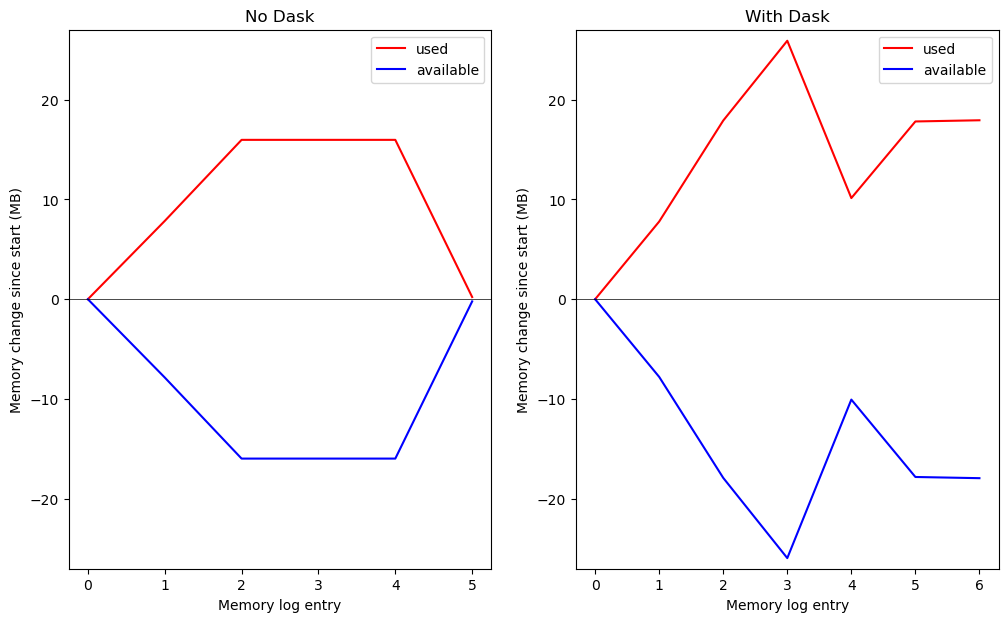

In [24]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(12,7))
ax[0].plot((np.asarray([memory_log[ind].used for ind in range(0,6)])\
            - memory_log[0].used)/(10**6),color='r',label='used')
ax[0].plot((np.asarray([memory_log[ind].available for ind in range(0,6)])\
            - memory_log[0].available)/(10**6),color='b',label='available')
ax[0].set_ylim([-27,27])
ax[0].axhline(y=0,color='k',lw=0.5)
ax[0].set_xlabel('Memory log entry')
ax[0].set_ylabel('Memory change since start (MB)')
ax[0].legend()
ax[0].set_title('No Dask')
ax[1].plot((np.asarray([memory_log[ind].used for ind in range(8,15)])\
            - memory_log[8].used)/(10**6),color='r',label='used')
ax[1].plot((np.asarray([memory_log[ind].available for ind in range(8,15)])\
            - memory_log[8].available)/(10**6),color='b',label='available')
ax[1].set_ylim([-27,27])
ax[1].axhline(y=0,color='k',lw=0.5)
ax[1].set_xlabel('Memory log entry')
ax[1].set_ylabel('Memory change since start (MB)')
ax[1].legend()
ax[1].set_title('With Dask')
plt.show()

With NumPy only (no Dask) we were able to recover essentially all of the memory we used during the computation. With Dask we achieved a net loss of ~10 MB at entry #4 on the right (just over the size of one of the arrays) before losing more memory when saving `copy_array_3` to disk.

It is worth remembering that Dask can also significantly *help* you limit the memory usage in your workspace (as we saw earlier with a [reduction operation](#Dask-arrays-and-delayed-computations))...even though you relinquish some control over memory management when using it.

## Xarray and memory management

### Un-requested data caching

The [xarray](https://docs.xarray.dev/en/stable/) package can open data files as Dask arrays using `open_mfdataset`, which is very useful for limiting memory usage in your workspace. `xarray.open_mfdataset` opens individual variables in a data file as Dask arrays, so that you get a "lazy" view of a file (or many files concatenated together) without immediately loading data into memory. However, when data chunks *are* loaded into memory using `.compute`, this data is typically cached to speed up future loads of the same data. This results in unintended memory usage that might be problematic depending on the size of the loaded data, the data chunks, and the limitations of your computing environment. 

Consider a case where we load (compute) into memory the monthly sea surface temperature (SST) from ECCO, 1992-2017.

In [ ]:
import numpy as np
import xarray as xr
from os.path import join,expanduser
import glob
import psutil

user_home_dir = expanduser('~')

# indicate whether you are working in a cloud instance (True if yes, False otherwise)
incloud_access = False


## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')



ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
# if working in the AWS cloud, download data to local instance if memory is available
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='1992-01',EndDate='2017-12',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=ECCO_dir)

## Load the model grid
if incloud_access == True:
    ecco_grid = xr.open_dataset(files_dict[ShortNames_list[0]])
else:
    ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])


## Open ECCO monthly mean T/S files
if incloud_access == True:
    ecco_TS = xr.open_mfdataset(files_dict[ShortNames_list[1]],\
                                      data_vars='minimal',coords='minimal',compat='override',\
                                      parallel=False)
else:
    ecco_TS = xr.open_mfdataset(join(ECCO_dir,'*_TEMP_SALINITY_LLC0090GRID_MONTHLY*','*.nc'),\
                                           data_vars='minimal',coords='minimal',compat='override',\
                                           parallel=False)

In [4]:
## merge grid and temperature datasets
ds = xr.merge((ecco_grid,ecco_TS[['THETA']]))

ds

<xarray.Dataset> Size: 7GB
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2, time: 312)
Coordinates: (12/21)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zu       (k_u) float32 200B ...
    Zl       (k_l) float32 200B ...
    XC_bnds  (tile, j, i, nb) float32 2MB ...
    YC_bnds  (tile, j, i, nb) float32 2MB ...
    Z_bnds   (k, nv) float32 400B ...
  * time     (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 2017-12-16T06:...
Dimensions without coordinates: nb, nv
Data variables: (12/22)
    CS       (tile, j, i) float32 421kB ...
    SN       (tile, j, i) float32 421kB ...
    rA       (tile, j, i) float32 421kB ...
    dxG      (tile, j_g, i) float32 421kB ...
    dyG      (tile, j, i_g) float32 421kB ...
    Depth    (tile, j, i) float32 421kB ...
    ...       ...
    hFacW    (k, tile, j, i_g) float32 21MB ...
    hFacS    (k, tile, j_g, i) float32 21MB ...
    maskC    (k, tile, j, i) bool 5MB ...
    maskW    (k, tile, j, i_g) bool 5MB ...
    maskS    (k, tile, j_g, i) bool 5MB ...
    THETA    (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [5]:
# compute temperature for top level
memory_log = [psutil.virtual_memory()]
SST_computed = ds.THETA.isel(k=0).compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -1981.464576  MB


But wait...should the temperature at 1 depth level take up ~2 GB of memory?

In [6]:
print('SST_computed data type:',temp_cum_depthavg.dtype)
print('SST_computed number of elements:',temp_cum_depthavg.size)
print('Estimated memory footprint of SST_computed:',(4*temp_cum_depthavg.size)/(10**6),'MB')

temp_cum_depthavg data type: float32
temp_cum_depthavg number of elements: 32853600
Estimated memory footprint of temp_cum_depthavg: 131.4144 MB


So why was so much more memory used than the size of the array itself? When `.compute` is invoked on a dataset sourced from file(s) using `open_mfdataset`, any chunk that is accessed is also cached (presumably to make subsequent loads of that data faster). So what are the chunk sizes in the `k` dimension?

In [33]:
k_dimnum = list(ds.THETA.dims).index('k')
ds.THETA.chunks[k_dimnum]

(25, 25)

The array is divided in 2 chunks in the `k` dimension each of size 25. So even if we are only using `.compute` on a single depth level, 25 depth levels are being cached (in a somewhat compressed format) and using up memory. Note that even if we re-chunk the dataset or data array after accessing the file(s), caching happens according to the native chunk sizes of the file. And at least in my experience, passing the option `cache=False` to `open_mfdataset` does not change the memory usage.

So what can we do? One option is to align our workflow more closely with the native chunking of the source file(s). **At this point I recommend restarting the kernel of this notebook so we can get a fresh open of the data files.**

In [1]:
%%time

import numpy as np
import xarray as xr
from os.path import join,expanduser
import glob
import psutil

user_home_dir = expanduser('~')

# indicate whether you are working in a cloud instance (True if yes, False otherwise)
incloud_access = False


## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')



ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
# if working in the AWS cloud, download data to local instance if memory is available
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='1992-01',EndDate='2017-12',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=ECCO_dir)

## Load the model grid
if incloud_access == True:
    ecco_grid = xr.open_dataset(files_dict[ShortNames_list[0]])
else:
    ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])


## Open ECCO monthly mean T/S files
if incloud_access == True:
    ecco_TS = xr.open_mfdataset(files_dict[ShortNames_list[1]],\
                                      data_vars='minimal',coords='minimal',compat='override',\
                                      parallel=False)
else:
    ecco_TS = xr.open_mfdataset(join(ECCO_dir,'*_TEMP_SALINITY_LLC0090GRID_MONTHLY*','*.nc'),\
                                           data_vars='minimal',coords='minimal',compat='override',\
                                           parallel=False)

## merge grid and temperature datasets
ds = xr.merge((ecco_grid,ecco_TS[['THETA']]))

# compute temperature for top level, by looping through time chunks
memory_log = [psutil.virtual_memory()]
SST_computed = ds.THETA.isel(k=0)
SST_computed_array = np.empty(SST_computed.shape).astype('float32')
for time_ind in range(ds.THETA.sizes['time']):
    SST_computed_array[time_ind,...] = ds.THETA.isel(time=time_ind,k=0).compute()
SST_computed.data = SST_computed_array

memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -1915.035648  MB
CPU times: user 38.7 s, sys: 4.03 s, total: 42.8 s
Wall time: 44.6 s


In the code above we did explicitly something that Dask does behind the scenes...looped through chunks so that our data loads are done in smaller pieces. But the change in memory is about the same as before, because by the end of the loop all of the top 25 depth levels of `THETA` have been cached. 

### A workaround to save workspace memory

There is one more trick up our sleeves to try to flush out the cache...re-open the data files on each loop iteration using `open_mfdataset`. This should have the effect of replacing our cache-linked dataset object with a clean "lazy" dataset (no data loaded or cached).

And since calls to `open_mfdataset` involving hundreds of files take time, and this would be repeated hundreds of times, we will [pickle](https://docs.python.org/3/library/pickle.html) the dataset object so that it can be re-used quickly. Essentially what we are doing is saving the "pointers" to the file contents, while flushing out the cache on each loop iteration.

Let's **restart the kernel one more time** before running the following code.

In [1]:
%%time

import numpy as np
import xarray as xr
from os.path import join,expanduser
import glob
import psutil

user_home_dir = expanduser('~')

# indicate whether you are working in a cloud instance (True if yes, False otherwise)
incloud_access = False


## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')



ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
# if working in the AWS cloud, download data to local instance if memory is available
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='1992-01',EndDate='2017-12',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=ECCO_dir)

## Load the model grid
if incloud_access == True:
    ecco_grid = xr.open_dataset(files_dict[ShortNames_list[0]])
else:
    ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])


## Open ECCO monthly mean T/S files
if incloud_access == True:
    ecco_TS = xr.open_mfdataset(files_dict[ShortNames_list[1]],\
                                      data_vars='minimal',coords='minimal',compat='override',\
                                      parallel=False)
else:
    ecco_TS = xr.open_mfdataset(join(ECCO_dir,'*_TEMP_SALINITY_LLC0090GRID_MONTHLY*','*.nc'),\
                                           data_vars='minimal',coords='minimal',compat='override',\
                                           parallel=False)

# pickle ecco_TS dataset object
import pickle
ecco_TS_pickled = pickle.dumps(ecco_TS)

## merge grid and temperature datasets
ds = xr.merge((ecco_grid,ecco_TS[['THETA']]))

# compute temperature for top level, by looping through time chunks
# while re-opening and closing ecco_TS dataset on each loop iteration
memory_log = [psutil.virtual_memory()]
SST_computed = ds.THETA.isel(k=0)
SST_computed_array = np.empty(SST_computed.shape).astype('float32')
for time_ind in range(ds.THETA.sizes['time']):
    # re-load pickled dataset object (equivalent to calling open_mfdataset again, but much quicker)
    ecco_TS = pickle.loads(ecco_TS_pickled)
    # compute SST for current time chunk
    SST_computed_array[time_ind,...] = ds.THETA.isel(time=time_ind,k=0).compute()
    # close dataset object
    ecco_TS.close()
SST_computed.data = SST_computed_array

memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -144.060416  MB
CPU times: user 1min 10s, sys: 4.22 s, total: 1min 15s
Wall time: 1min 18s


Our memory usage now is only slightly over the expected footprint of the SST array itself, rather than ~15 times larger! The trade-off is that it took a little longer to load the data into memory with the "opening" and closing of the dataset object on each iteration.

Note that it is `ecco_TS` that we have flushed the cache from, **not** `ds`. This procedure needs to be applied to the dataset object associated with the initial `open_mfdataset` call, rather than any subsequent datasets that it might be merged or concatenated into.

To review, the procedure to flush the cache associated with `open_mfdataset` is:

- When loading data explicitly in smaller "chunks", be sure to loop through the dataset in ways that are well aligned with the pre-existing chunking of the source files.

- Before calling `.compute`, "re-open" the dataset by calling `open_mfdataset` (or a pickled equivalent).

- Load your chunk into memory using `.compute`.

- Close the dataset object (this may not be strictly necessary, but is a good practice for clean coding).



And now, just to be sure that it is SST that we have loaded, and because it is fun to end a tutorial by plotting data, let's look at the ECCO climatological SST for January and July.

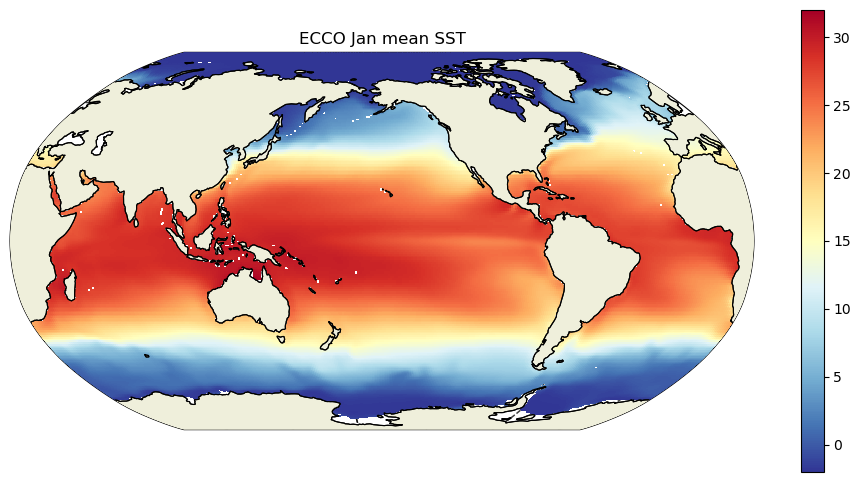

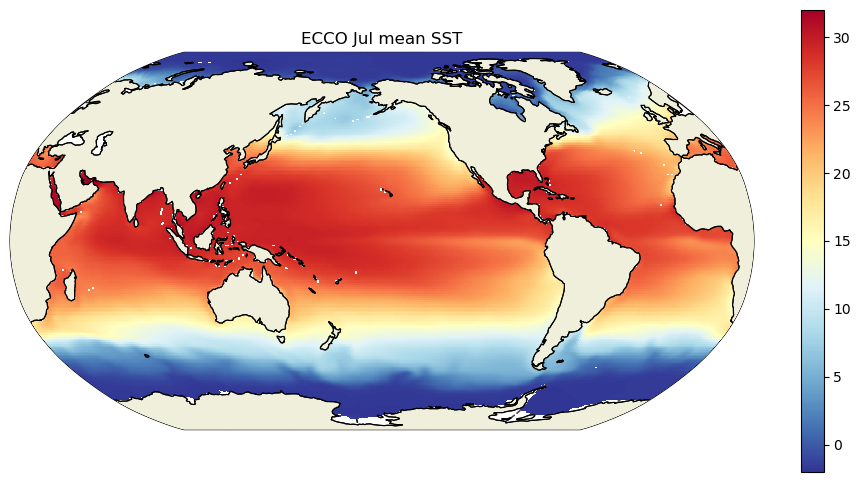

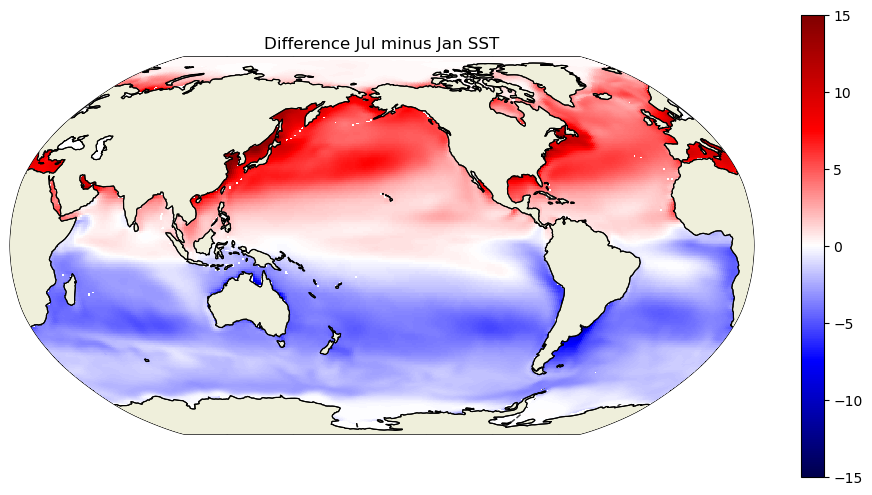

In [13]:
import matplotlib.pyplot as plt
import ecco_v4_py as ecco

dx = .25
dy = .25
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,\
                              SST_computed.isel(time=slice(0,None,12)).mean('time'),\
                              dx=dx,dy=dy,user_lon_0=200,\
                              cmin=-2,cmax=32,show_colorbar=True,cmap='RdYlBu_r')
plt.title('ECCO Jan mean SST')
plt.show()

plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,\
                              SST_computed.isel(time=slice(6,None,12)).mean('time'),\
                              dx=dx,dy=dy,user_lon_0=200,\
                              cmin=-2,cmax=32,show_colorbar=True,cmap='RdYlBu_r')
plt.title('ECCO Jul mean SST')
plt.show()

plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,\
                              SST_computed.isel(time=slice(6,None,12)).mean('time')\
                              - SST_computed.isel(time=slice(0,None,12)).mean('time'),\
                              dx=dx,dy=dy,user_lon_0=200,\
                              cmin=-15,cmax=15,show_colorbar=True,cmap='seismic')
plt.title('Difference Jul minus Jan SST')
plt.show()